In [2]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

In [3]:

def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data

data = readArxivFile('arxiv-metadata-oai-snapshot.json', ['id', 'abstract', 'categories', 'comments'])

In [4]:
# 使用正则表达式匹配，XX pages
print(data['comments'])
data['pages'] = data['comments'].apply(lambda x: re.findall('[1-9][0-9]* pages', str(x)))
print(data['pages'])

# 筛选出有pages的论文
data = data[data['pages'].apply(len) > 0]

# 由于匹配得到的是一个list，如['19 pages']，需要进行转换
data['pages'] = data['pages'].apply(lambda x: float(x[0].replace(' pages', '')))
print(data['pages'])

0                    37 pages, 15 figures; published version
1                      To appear in Graphs and Combinatorics
2                                        23 pages, 3 figures
3                                                   11 pages
4                                                       None
                                 ...                        
1796906    19 pages, LaTex, 6 PostScript figures; Author'...
1796907    4 pages, LaTeX type, Uses IEEE style files, 60...
1796908    20 pages, LaTeX type, Uses REVTeX style files,...
1796909    7 pages, 4 PostScript Figures, LaTeX, to appea...
1796910    12 pages including 8 eps figs, LaTeX with jpsj...
Name: comments, Length: 1796911, dtype: object
0          [37 pages]
1                  []
2          [23 pages]
3          [11 pages]
4                  []
              ...    
1796906    [19 pages]
1796907     [4 pages]
1796908    [20 pages]
1796909     [7 pages]
1796910    [12 pages]
Name: pages, Length: 1796911, dtype: obj

In [5]:
#data['pages'].describe()
data['pages'].describe().astype(int)

count    1089180
mean          17
std           22
min            1
25%            8
50%           13
75%           22
max        11232
Name: pages, dtype: int32

<AxesSubplot:xlabel='categories'>

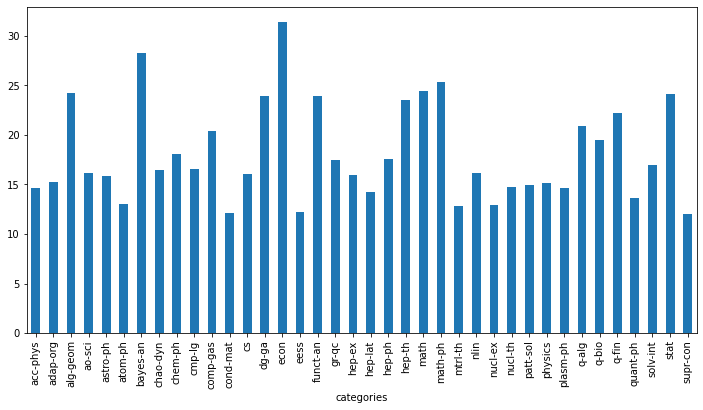

In [6]:
# 选择主要类别
data['categories'] = data['categories'].apply(lambda x: x.split(' ')[0])
data['categories'] = data['categories'].apply(lambda x: x.split('.')[0])

# 每类论文的平均页数
plt.figure(figsize=(12, 6))
data.groupby(['categories'])['pages'].mean().plot(kind='bar')

In [7]:
data['figures'] = data['comments'].apply(lambda x: re.findall('[1-9][0-9]* figures', str(x)))
print(data['figures'])
data = data[data['figures'].apply(len) > 0]
data['figures'] = data['figures'].apply(lambda x: float(x[0].replace(' figures', '')))
print(data['figures'])
data['figures'].describe().astype(int)

0          [15 figures]
2           [3 figures]
3                    []
5           [4 figures]
6                    []
               ...     
1796906              []
1796907              []
1796908              []
1796909              []
1796910              []
Name: figures, Length: 1089180, dtype: object
0          15.0
2           3.0
5           4.0
9          17.0
15          3.0
           ... 
1796880     6.0
1796885     7.0
1796890     3.0
1796894     4.0
1796902     8.0
Name: figures, Length: 621783, dtype: float64


count    621783
mean          7
std          10
min           1
25%           4
50%           6
75%           9
max        4989
Name: figures, dtype: int32

<AxesSubplot:xlabel='categories'>

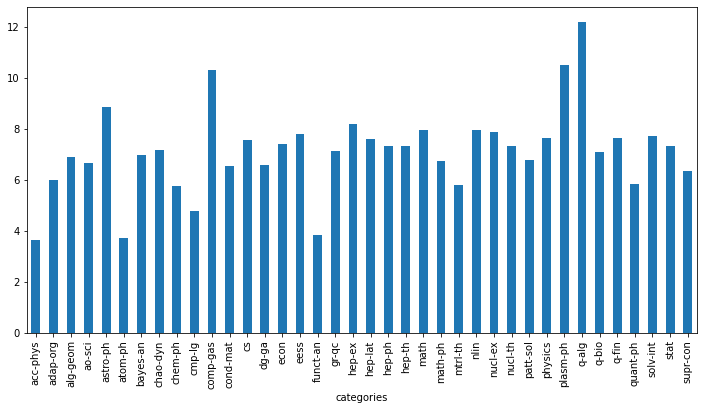

In [8]:
# 选择主要类别
data['categories'] = data['categories'].apply(lambda x: x.split(' ')[0])
data['categories'] = data['categories'].apply(lambda x: x.split('.')[0])

# 每类论文的平均页数
plt.figure(figsize=(12, 6))
data.groupby(['categories'])['figures'].mean().plot(kind='bar')

In [11]:
# 筛选包含github的论文
data_with_code = data[
    (data.comments.str.contains('github')==True)|
                      (data.abstract.str.contains('github')==True)
]
print(data_with_code)
print(data_with_code['abstract'])
print(data_with_code['comments'])

data_with_code['text'] = data_with_code['abstract'].fillna('') + data_with_code['comments'].fillna('')

print(data_with_code['abstract'])
print(data_with_code['comments'])
print("######"+data_with_code['text'])

# 使用正则表达式匹配论文
pattern = '[a-zA-z]+://github[^\s]*'
data_with_code['code_flag'] = data_with_code['text'].str.findall(pattern).apply(len)
print(data_with_code['code_flag'])

                 id                                           abstract  \
253172    1103.5904    Solar tomography has progressed rapidly in r...   
254226    1104.0672    We describe a hybrid Fourier/direct space co...   
296182    1110.4876    REBOUND is a new multi-purpose N-body code w...   
300298    1111.2062    This article proposes a way to improve the p...   
311500    1112.5945    The interaction of distinct units in physica...   
...             ...                                                ...   
1381266  2011.08518    Sequence-based place recognition methods for...   
1381310  2011.08562    The target identification in brain-computer ...   
1381509  2011.08761    In this paper, we study the problem of imagi...   
1381606  2011.08858    We derive a simple prescription for includin...   
1382418  2011.09670    Rotation detection serves as a fundamental b...   

        categories                                           comments  pages  \
253172    astro-ph             

<ipython-input-11-7ea3cd8f8a99>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_code['text'] = data_with_code['abstract'].fillna('') + data_with_code['comments'].fillna('')
<ipython-input-11-7ea3cd8f8a99>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_code['code_flag'] = data_with_code['text'].str.findall(pattern).apply(len)


                 id                                           abstract  \
254226    1104.0672    We describe a hybrid Fourier/direct space co...   
296182    1110.4876    REBOUND is a new multi-purpose N-body code w...   
311500    1112.5945    The interaction of distinct units in physica...   
317016    1201.5029    There are a number of different phenomena in...   
330675    1203.5316    We study the thermalization process in the s...   
...             ...                                                ...   
1380713  2011.07965    Analyzing large datasets with distributed da...   
1381048  2011.08300    We present an instance of a task of mininum-...   
1381227  2011.08479    In this work, we study the dynamics of parti...   
1381310  2011.08562    The target identification in brain-computer ...   
1381606  2011.08858    We derive a simple prescription for includin...   

        categories                                           comments  pages  \
254226    astro-ph  10 pages, 6

<AxesSubplot:xlabel='categories'>

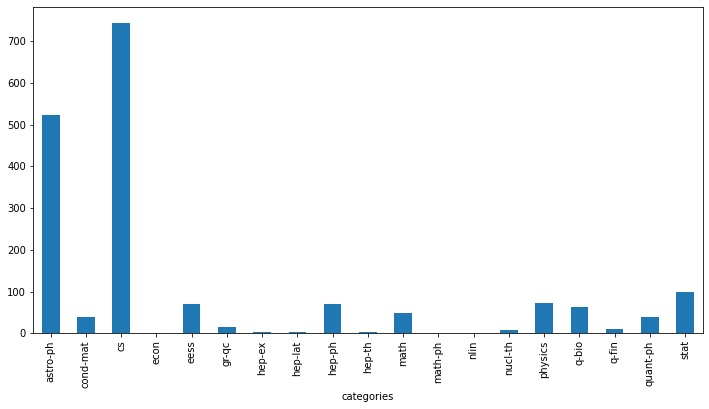

In [12]:
data_with_code = data_with_code[data_with_code['code_flag'] == 1]
print(data_with_code)
plt.figure(figsize=(12, 6))
data_with_code.groupby(['categories'])['code_flag'].count().plot(kind='bar')